In [164]:
import numpy as np
import torch
import random 
import plotly.express as px
from pathlib import Path
import pyvista as pv
import sys
import pandas as pd
import pint
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import yaml

In [165]:
sys.path.append(str(Path.cwd().parent))

In [166]:
from src.offline_stage import NirbModule, NirbDataModule, get_n_outputs
from comsol_module import COMSOL_VTU
from src.pod import MeanNormalizer, MinMaxNormalizer, Standardizer
from comsol_module.helper import calculate_normal
from src.utils import (load_pint_data,
                       safe_parse_quantity,
                       format_quantity,
                       Q2_metric,
                       calculate_thermal_entropy_generation,
                       read_config)

In [167]:
PARAMETER_SPACE = "07"
ACCURACY = 1e-5
ROOT = Path.cwd().parent / "data" / PARAMETER_SPACE
ROOT.exists()
IS_SAVE_PNG = False
SUFFIX = "min_max"
INFER_META_DATA = True
FIELD_NAME = "Temperature" # "Entropy" #"Temperature"
PROJECTION = "Original"
is_clean_mesh = False
ureg = pint.get_application_registry()
config = read_config()
control_mesh_suffix =  "s100_100_100_b0_4000_0_5000_-4000_-0"
version = "version_1"


### Load checkpoints from different trainings

In [168]:
if not INFER_META_DATA:
    chk_pt_paths = [path for path in (ROOT / f"nn_logs_{ACCURACY:.1e}{SUFFIX}").rglob("*.ckpt")]
    chk_pt_paths = sorted(chk_pt_paths, key = lambda p: p.parent.parent.stem)
    chk_pt_paths_dict = dict()
    for idx, path in enumerate(chk_pt_paths):
        print(f"{idx:02d} ({path.parent.parent.stem}): {path.name}")
        chk_pt_paths_dict[path.parent.parent.stem] = path

### Load checkpoint

In [169]:

if not INFER_META_DATA:
    # Select checkpoint
    version = "version_1"
    chk_pt_path = chk_pt_paths_dict[version]
    print(chk_pt_path.relative_to(chk_pt_path.parents[2]))
else:
    # chk_pt_path = Path(ROOT / 'optuna_logs/trial_87/checkpoints/epoch=18799-Q2_val=1.98e-03.ckpt')
    
    # chk_pt_path = "/Users/thomassimader/Documents/NIRB/data/03/optuna_logs/trial_17/checkpoints/epoch=22199-Q2_val=1.42e-03.ckpt"
    chk_pt_path = Path("/Users/thomassimader/Library/CloudStorage/OneDrive-geomeconGmbH/PhD/NIRB/data/07/optuna_logs/trial_17/checkpoints/epoch=13833-Q2_val=6.89e-04.ckpt")
    
    # chk_pt_path = Path("/Users/thomassimader/Library/CloudStorage/OneDrive-geomeconGmbH/PhD/NIRB/data/07/optuna_logs/trial_22/checkpoints/epoch=8999-Q2_val=8.22e-04.ckpt")
    # chk_pt_path = Path("/Users/thomassimader/Library/CloudStorage/OneDrive-geomeconGmbH/PhD/NIRB/data/07/optuna_logs/trial_48/checkpoints/epoch=16499-Q2_val=8.35e-04.ckpt")
    # chk_pt_path = Path("/Users/thomassimader/Library/CloudStorage/OneDrive-geomeconGmbH/PhD/NIRB/data/07/optuna_logs/trial_21/checkpoints/last-v1.ckpt")
   
    # chk_pt_path = "/Users/thomassimader/Library/CloudStorage/OneDrive-geomeconGmbH/PhD/NIRB/data/08/optuna_logsEntropy/trial_22/checkpoints/epoch=6999-Q2_val=1.72e-04.ckpt"
    chk_pt_path = Path(chk_pt_path)
    assert chk_pt_path.exists()
print(chk_pt_path)
trained_model : NirbModule = NirbModule.load_from_checkpoint(chk_pt_path)

/Users/thomassimader/Library/CloudStorage/OneDrive-geomeconGmbH/PhD/NIRB/data/07/optuna_logs/trial_17/checkpoints/epoch=13833-Q2_val=6.89e-04.ckpt


/Users/thomassimader/Library/CloudStorage/OneDrive-geomeconGmbH/PhD/NIRB/.venv/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:209: UserWarning:

Attribute 'activation' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['activation'])`.



In [170]:
df_basis_functions = pd.read_csv(ROOT / f"df_basis_functions_{FIELD_NAME}.csv")

In [171]:
trained_model = trained_model.to('cpu')
trained_model.eval()

NirbModule(
  (loss): MSELoss()
  (activation): LeakyReLU(negative_slope=0.01)
  (model): NIRB_NN(
    (layers): Sequential(
      (0): Linear(in_features=1, out_features=294, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=294, out_features=104, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Linear(in_features=104, out_features=114, bias=True)
      (5): LeakyReLU(negative_slope=0.01)
      (6): Linear(in_features=114, out_features=29, bias=True)
    )
  )
  (msa_metric): MeanAbsoluteError()
)

In [172]:
n_outputs = get_n_outputs(trained_model)
filtered_basis_df = df_basis_functions.loc[df_basis_functions['n_basis'] == n_outputs]
assert len(filtered_basis_df) == 1

ACCURACY = filtered_basis_df.accuracy.values[0]
SUFFIX = filtered_basis_df.suffix.values[0]
basis_function_path = filtered_basis_df.path.values[0]
print(f'{ACCURACY=}')
print(f'{SUFFIX=}')
print(f'{basis_function_path=}')


ACCURACY=np.float64(1e-06)
SUFFIX='mean'
basis_function_path='/Users/thomassimader/Library/CloudStorage/OneDrive-geomeconGmbH/PhD/NIRB/data/07/BasisFunctionsTemperature/basis_fts_matrix_1.0e-06mean.npy'


#### Infer Scaling

In [173]:
with open(chk_pt_path.parents[1] / "hparams.yaml", "r") as file:
    hparam = yaml.unsafe_load(file)

In [174]:
scaler_features = hparam["scaler_features"]
scaler_outputs = hparam["scaler_outputs"]
scaler_features = "MinMax"
print(f"{scaler_features=}")
print(f"{scaler_outputs=}")


scaler_features='MinMax'
scaler_outputs='Mean'


### Load Data

In [175]:
basis_functions             = np.load(basis_function_path)
training_parameters         = load_pint_data(ROOT / "training_samples.csv", is_numpy = True)
test_parameters             = load_pint_data(ROOT / "test_samples.csv", is_numpy = True)
test_parameters_pint        = load_pint_data(ROOT / "test_samples.csv")
train_parameters_pint        = load_pint_data(ROOT / "training_samples.csv")
# comsol_data = COMSOL_VTU(ROOT / "TrainingMapped" / control_mesh_suffix /f"Training_000_{control_mesh_suffix}.vtu")
comsol_data = COMSOL_VTU(ROOT / f"Training{PROJECTION}" / "Training_000.vtu", is_clean_mesh=is_clean_mesh)
comsol_data.mesh.clear_data()


In [ ]:
if PROJECTION == "Mapped":
    export_root_train = ROOT / f"Training{PROJECTION}" / control_mesh_suffix / "Exports"
    export_root_test = ROOT / f"Test{PROJECTION}" / control_mesh_suffix / "Exports"
else:
    export_root_train = ROOT / f"Training{PROJECTION}" 
    export_root_test = ROOT / f"Test{PROJECTION}"
    
assert export_root_train.exists(), f"Export root train {export_root_train} does not exist."
assert export_root_test.exists(), f"Export root test {export_root_test} does not exist."

match FIELD_NAME:
    case "Temperature":
        if 'init' in SUFFIX.lower() and 'grad' in SUFFIX.lower():
            training_snapshots_npy      = np.load(export_root_train / f"Training_{FIELD_NAME}_minus_tgrad.npy")
            test_snapshots_npy          = np.load(export_root_test / f"Test_{FIELD_NAME}_minus_tgrad.npy")
            training_snapshots  = training_snapshots_npy[:, -1, :]
            test_snapshots      = test_snapshots_npy[:, -1, :]
        else:
            training_snapshots_npy      = np.load(export_root_train / f"Training_{FIELD_NAME}.npy")
            test_snapshots_npy          = np.load(export_root_test / f"Test_{FIELD_NAME}.npy")
            training_snapshots  = training_snapshots_npy[:, -1, :]
            test_snapshots      = test_snapshots_npy[:, -1, :]
    case "Entropy":
        training_snapshots_npy      = np.load(export_root_train / "Training_entropy_gen_per_vol_thermal.npy")
        test_snapshots_npy          = np.load(export_root_test / "Test_entropy_gen_per_vol_thermal.npy")
        training_snapshots  = training_snapshots_npy[:, -1, :]
        test_snapshots      = test_snapshots_npy[:, -1, :]   

In [ ]:
if PARAMETER_SPACE == "01":
    training_parameters[:, 0] = np.log10(training_parameters[:, 0])
    test_parameters[:, 0] = np.log10(test_parameters[:, 0])

N = len(test_snapshots)


In [ ]:
print(test_snapshots_npy.shape)
print(training_snapshots_npy.shape)

(20, 36, 20168)
(150, 36, 20168)


In [ ]:
np.asarray(basis_functions).shape

(29, 20168)

In [ ]:
if "mean" in SUFFIX.lower():
    scaling = MeanNormalizer()
elif "min_max" in SUFFIX.lower():
    scaling = MinMaxNormalizer()
elif "standard" in SUFFIX.lower():
    scaling = Standardizer()
else:
    raise ValueError("Invalid suffix.")

if "min_max" in scaler_features.lower() or "minmax" in scaler_features.lower():
    scaling_features = MinMaxNormalizer()
elif "mean" in scaler_features.lower():
    scaling_features = MeanNormalizer()
elif "standard" in scaler_features.lower():
    scaling_features = Standardizer()
else:
    raise ValueError(f"Invalid scaler_features: {scaler_features}")


data_module = NirbDataModule(
    basis_func_mtrx=basis_functions,
    training_snaps=training_snapshots,
    test_snaps=test_snapshots,
    training_param=training_parameters,
    test_param=test_parameters,
    normalizer=scaling,
    standardizer_features= scaling_features
)

### Parameters

In [ ]:
param_folder = ROOT / "Exports"
param_files = sorted([file for file in param_folder.rglob("*.csv") if "test" in file.stem.lower()])
assert len(param_files) == len(data_module.test_snaps_scaled)

### Prepare Plot

In [ ]:
random.seed(3123)
# samples = random.sample(range(len(test_snapshots)), N)
samples = np.arange(N)
samples = np.delete(samples, [1, 8, 11, 15,17], axis=None)
colors = px.colors.sample_colorscale("thermal", [n/(N -1) for n in range(N)])
print(samples)

[ 0  2  3  4  5  6  7  9 10 12 13 14 16 18 19]


### Predict Test

In [ ]:
param = data_module.test_param_scaled[samples]
param_t = torch.from_numpy(param.astype(np.float32))
predicted_coefficients = trained_model(param_t).detach().numpy()
predictions = np.matmul(predicted_coefficients, data_module.basis_func_mtrx)

In [ ]:
test_snapshots = data_module.test_snaps_scaled
q2_scaled = Q2_metric(test_snapshots[samples], predictions)
print(f"Q2 = {q2_scaled:.3e}")

Q2 = 2.468e-01


### Predicted coefficients vs true coefficients

In [ ]:
n_points = np.arange(1, basis_functions.shape[0] + 1)
lw = 1.5
fig = make_subplots(
    rows=4, cols=1,
    subplot_titles=("True Coefficients", "Predicted Coefficients", "Difference (Predicted - True)" ,"MSE"),
    vertical_spacing=0.15,
    shared_xaxes=True,
)

squarred_differences = np.zeros((len(samples), basis_functions.shape[0]))
colors = px.colors.sample_colorscale("rainbow", [n/(len(samples)) for n in range(len(samples))])
# Add traces for each sample
for idx, (test_coeffcient, predicted_coefficient) in enumerate(zip(data_module.test_coeff[samples], predicted_coefficients)):
    # Extend the step by adding one more point
    # test_coeffcient = np.append(test_coeffcient, test_coeffcient[-1])  #  Duplicate the last y-value
    # predicted_coefficient = np.append(predicted_coefficient, predicted_coefficient[-1])      # Duplicate the last y-value
    # n_points = np.append(n_points, n_points[-1] + 1)     # Add an extra x-value (e.g. +1) #
    legend_grp = f"Sample {samples[idx]:03d}"
    fig.add_trace(
        go.Scatter(x=n_points, y=test_coeffcient, mode='lines+markers', line_shape='linear', 
                   opacity=0.5, line=dict(width=lw, color = colors[idx]), showlegend=True,
                   name ="", # f"Sample {samples[idx]:03d} - Test",
                   legendgroup=str(idx), legendgrouptitle=dict(text=legend_grp)),
        row=1, col=1
    )
    fig.add_trace(
        go.Scatter(x=n_points, y=predicted_coefficient,
                   mode='lines+markers',
                   line_shape='linear', 
                   opacity=0.5, line=dict(width=lw, color = colors[idx]),
                   showlegend=False,
                   name = f"Sample {samples[idx]:03d}- Prediction",
                   legendgroup=str(idx)),
        row=2, col=1
    )
    
    # Difference (prediction - test_snapshot) - Row 3
    difference = predicted_coefficient - test_coeffcient
    squarred_differences[idx, :] = difference**2
    fig.add_trace(
        go.Scatter(x=n_points, y=difference, mode='lines+markers', line_shape='linear',
                   opacity=0.6, line=dict(width=lw, color = colors[idx]), showlegend=False,
                   legendgroup=str(idx),
                   name=f"Difference {samples[idx]:03d}"),
        row=3, col=1
    )

# fig.add_trace(
#     go.Scatter(x=n_points, y=np.sum(squarred_differences, axis=0) / squarred_differences.shape[0], mode='markers', line_shape='linear',
#                 opacity=1., marker=dict(color = "red", size=10), showlegend=False),
#     row=4, col=1
# )
mse_values = np.sum(squarred_differences, axis=0) / squarred_differences.shape[0]
fig.add_trace(
    go.Bar(x=n_points, y=mse_values,  showlegend=False,
            text=mse_values,                 # <- Text to display
            texttemplate='%{y:,.2e}',  # comma for thousands, 2 decimals
        marker_color='royalblue'),
    row=4, col=1
)

# Update axes labels
fig.update_xaxes(title_text="Basis Function ID", row=4, col=1)
fig.update_yaxes(title_text="[-]", row=1, col=1)
fig.update_yaxes(title_text="[-]", row=2, col=1)
fig.update_yaxes(title_text="[-]", row=3, col=1)
fig.update_yaxes(title_text="[-]", row=4, col=1)

# Set overall layout
fig.update_layout(
    width=1500, height=1000,
    title_text=f"Parameter Space {PARAMETER_SPACE} (MSE = {np.mean(mse_values):.4e})",
    showlegend=True,
    legend=dict(
        orientation='h',        # Horizontal layout
        yanchor='top',          # Anchor legend at the top
    ),
)
if IS_SAVE_PNG:
    fig.write_html(ROOT / "Predictions" / f"Coefficients_{ACCURACY:.1e}{SUFFIX}_PS{PARAMETER_SPACE}_{FIELD_NAME}_{chk_pt_path.parents[1].stem}.html")
    fig.write_image(ROOT / "Predictions" / f"Coefficients_{ACCURACY:.1e}{SUFFIX}_PS{PARAMETER_SPACE}_{FIELD_NAME}_{chk_pt_path.parents[1].stem}.png")
fig.show()

### Plot test vs original

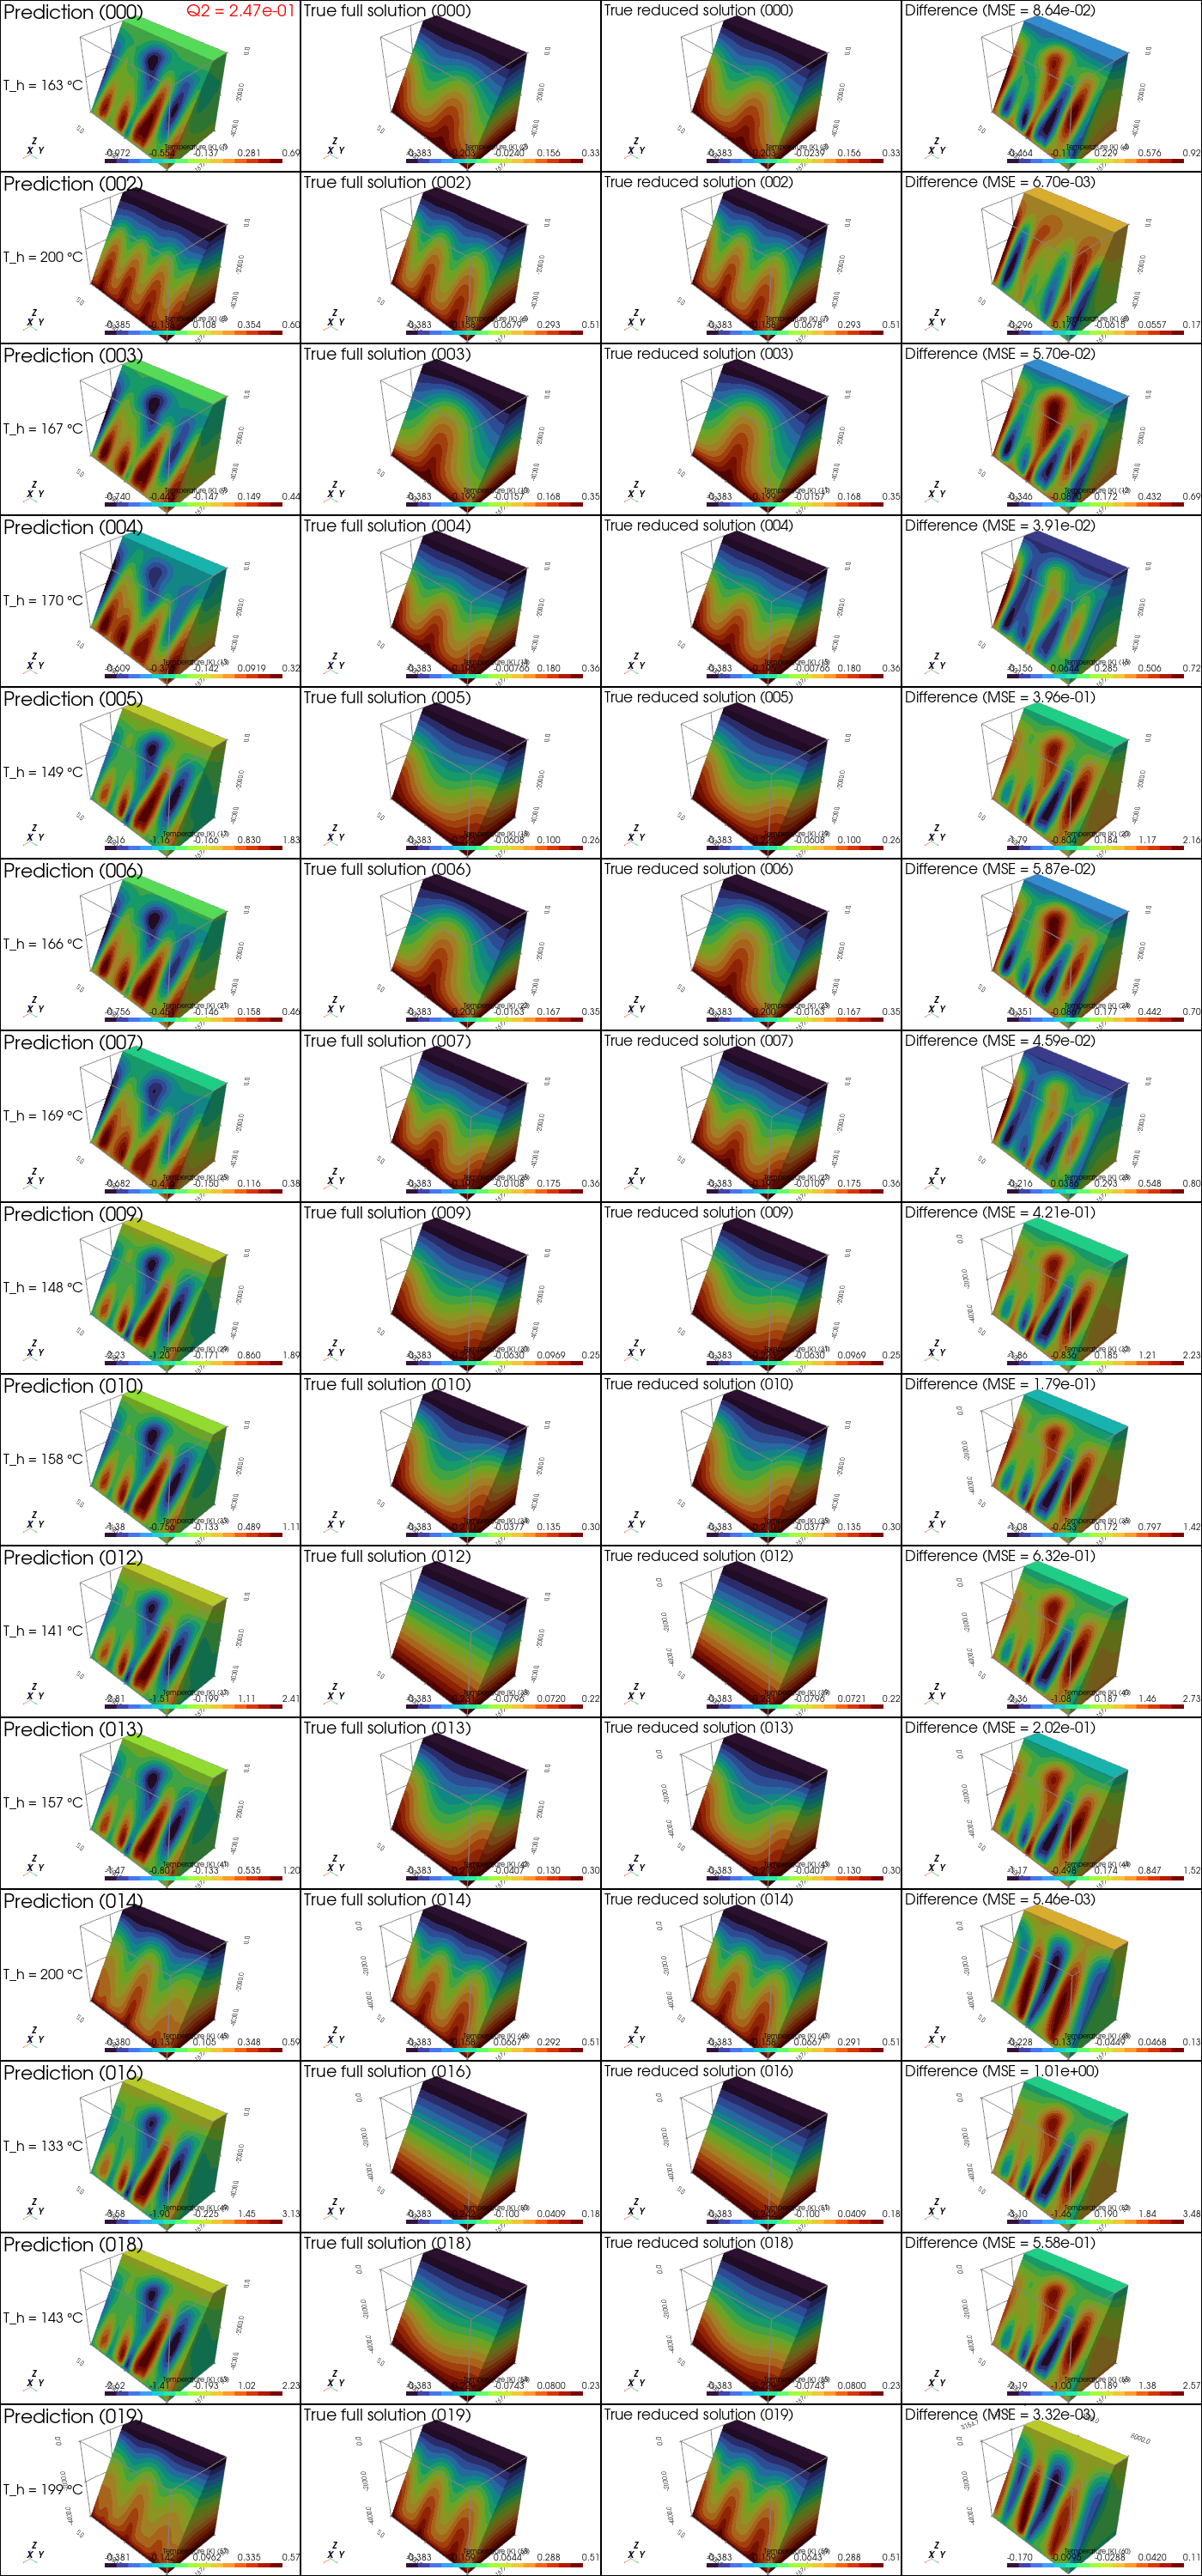

In [ ]:
# Initialize the figure
pv.set_jupyter_backend('static')
n_cols = 4  # number of columns 
plotter = pv.Plotter(shape=(len(samples), n_cols),
                     window_size=(1400, 3000), #  (width=1200px, height=800px)
                     off_screen=True)
counter = 0


# Loop through the samples and plot
for i, (prediction, sample_idx) in enumerate(zip(predictions, samples)):
    parameters_df_file = param_files[sample_idx]
    param_df = pd.read_csv(parameters_df_file, index_col = 0)
    param_df['quantity_pint'] = param_df[param_df.columns[-1]].apply(lambda x : safe_parse_quantity(x))
    dip = param_df.loc['dip', 'quantity_pint', ]
    strike = param_df.loc['strike', 'quantity_pint']
    normal = calculate_normal(dip.to('deg').magnitude, strike.to('deg').magnitude)

    plotter.subplot(i, 0)
    counter += 1
    field_name = f"Test Sample {sample_idx}"
    param_string =  "\n".join([f"{col} = {format_quantity(para, number_format = '.3g')}" for col, para in test_parameters_pint.loc[sample_idx].items()])
    
    comsol_data.mesh.point_data[field_name] = prediction
    clipped = comsol_data.mesh.clip(normal=-np.array(normal), origin = comsol_data.mesh.center)
    
    plotter.add_mesh(clipped, scalars=field_name,
                        cmap=config['cmap'],
                        scalar_bar_args={'title': f'Temperature [K] ({counter})',
                                        'label_font_size': 10,
                                        'title_font_size': 8,})
    plotter.add_text(f"Prediction ({sample_idx:03d})",
                     font_size=13)
    plotter.add_text(param_string,
                    position="left_edge",
                    font_size=9,)
    plotter.add_axes(line_width=1.)
    plotter.add_bounding_box()
    plotter.show_grid(
        font_size=6,
        n_xlabels=3,  # number of labels (ticks) on x-axis
        n_ylabels=3,  # number of labels (ticks) on y-axis
        n_zlabels=3,  # number of labels (ticks) on z-axis
        color='gray',
        xtitle='',
        ytitle='',
        ztitle='',
                        )
    plotter.subplot(i, 1)
    counter += 1
    comsol_data.mesh.point_data[field_name] = test_snapshots[sample_idx, :]
    clipped = comsol_data.mesh.clip(normal=-np.array(normal), origin = comsol_data.mesh.center)
    plotter.add_mesh(clipped, scalars=field_name,
                    cmap=config['cmap'],
                    scalar_bar_args={'title': f'Temperature [K] ({counter})',
                                    'label_font_size': 10,
                                    'title_font_size': 8,})
    plotter.add_text(f"True full solution ({sample_idx:03d})",
                     font_size=13)
    plotter.add_axes(line_width=1.)
    plotter.add_bounding_box()
    plotter.show_grid(
        font_size=6,
        n_xlabels=3,  # number of labels (ticks) on x-axis
        n_ylabels=3,  # number of labels (ticks) on y-axis
        n_zlabels=3,  # number of labels (ticks) on z-axis
        color='gray',
        xtitle='',
        ytitle='',
        ztitle='', )


    plotter.subplot(i, 2)
    counter += 1
    comsol_data.mesh.point_data[field_name] = np.matmul(data_module.test_coeff[sample_idx], data_module.basis_func_mtrx)
    clipped = comsol_data.mesh.clip(normal=-np.array(normal), origin = comsol_data.mesh.center)
    plotter.add_mesh(clipped, scalars=field_name,
                    cmap=config['cmap'],
                    scalar_bar_args={'title': f'Temperature [K] ({counter})',
                                    'label_font_size': 10,
                                    'title_font_size': 8,})
    plotter.add_text(f"True reduced solution ({sample_idx:03d})",
                     font_size=13)
    plotter.add_axes(line_width=1.)
    plotter.add_bounding_box()
    plotter.show_grid(
        font_size=6,
        n_xlabels=3,  # number of labels (ticks) on x-axis
        n_ylabels=3,  # number of labels (ticks) on y-axis
        n_zlabels=3,  # number of labels (ticks) on z-axis
        color='gray',
        xtitle='',
        ytitle='',
        ztitle='', )

    plotter.subplot(i, 3)
    counter += 1
    comsol_data.mesh.point_data[field_name] = test_snapshots[sample_idx, :] - prediction
    mse = np.mean((test_snapshots[sample_idx, :] - prediction)**2)
    clipped = comsol_data.mesh.clip(normal=-np.array(normal), origin = comsol_data.mesh.center)
    plotter.add_mesh(clipped, scalars=field_name,
                    cmap=config['cmap'],
                    scalar_bar_args={'title': f'Temperature [K] ({counter})',
                                    'label_font_size': 10,
                                    'title_font_size': 8,})
    plotter.add_text(f"Difference (MSE = {mse:.2e})",
                     font_size=13)
    plotter.add_axes(line_width=1.)
    plotter.add_bounding_box()
    plotter.show_grid(
        font_size=6,
        n_xlabels=3,  # number of labels (ticks) on x-axis
        n_ylabels=3,  # number of labels (ticks) on y-axis
        n_zlabels=3,  # number of labels (ticks) on z-axis
        color='gray',
        xtitle='',
        ytitle='',
        ztitle='', )


plotter.subplot(0, 0)
plotter.add_text(f"Q2 = {q2_scaled:.2e}", position='upper_right', font_size=10, color='red')

kwargs = {}
if IS_SAVE_PNG:
    kwargs["screenshot"] = ROOT / "Predictions" /f"ComparisonNirbOriginal_{ACCURACY:.1e}{SUFFIX}_PS{PARAMETER_SPACE}_{FIELD_NAME}_{chk_pt_path.parents[1].stem}.png"
plotter.show(**kwargs)



### Plot training vs prediction

In [ ]:
param_train = data_module.training_param_scaled
param_train_t = torch.from_numpy(param_train.astype(np.float32))
predicted_coefficients_train = trained_model(param_train_t).detach().numpy()
predictions_train = np.matmul(predicted_coefficients_train, data_module.basis_func_mtrx)
r2_scaled = Q2_metric(data_module.training_snaps_scaled, predictions_train)
print(f"R2 = {r2_scaled:.3e}")

R2 = 2.047e+00


In [ ]:
np.random.seed(124512)
train_samples = np.random.randint(0, len(data_module.training_snaps_scaled) - 1, size=20) 

In [ ]:
param_files_train = sorted([file for file in param_folder.rglob("*.csv") if "train" in file.stem.lower()])
assert len(param_files_train) == len(data_module.training_snaps_scaled)

In [ ]:
# Initialize the figure
pv.set_jupyter_backend('static')
n_cols = 4  # number of columns 
plotter = pv.Plotter(shape=(len(train_samples), n_cols),
                     window_size=(1400, 3000), #  (width=1200px, height=800px)
                     off_screen=True)
counter = 0


# Loop through the samples and plot
for i, (prediction, sample_idx) in enumerate(zip(predictions_train[train_samples], train_samples)):
    parameters_df_file = param_files_train[sample_idx]
    param_df = pd.read_csv(parameters_df_file, index_col = 0)
    param_df['quantity_pint'] = param_df[param_df.columns[-1]].apply(lambda x : safe_parse_quantity(x))
    dip = param_df.loc['dip', 'quantity_pint', ]
    strike = param_df.loc['strike', 'quantity_pint']
    normal = calculate_normal(dip.to('deg').magnitude, strike.to('deg').magnitude)

    plotter.subplot(i, 0)
    counter += 1
    field_name = f"Train Sample {sample_idx}"
    param_string =  "\n".join([f"{col} = {format_quantity(para, number_format = '.3g')}" for col, para in train_parameters_pint.loc[sample_idx].items()])
    
    comsol_data.mesh.point_data[field_name] = prediction
    clipped = comsol_data.mesh.clip(normal=-np.array(normal), origin = comsol_data.mesh.center)
    
    plotter.add_mesh(clipped, scalars=field_name,
                        cmap=config['cmap'],
                        scalar_bar_args={'title': f'Temperature [K] ({counter})',
                                        'label_font_size': 10,
                                        'title_font_size': 8,})
    plotter.add_text(f"Prediction ({sample_idx:03d})",
                     font_size=13)
    plotter.add_text(param_string,
                    position="left_edge",
                    font_size=9,)
    plotter.add_axes(line_width=1.)
    plotter.add_bounding_box()
    plotter.show_grid(
        font_size=6,
        n_xlabels=3,  # number of labels (ticks) on x-axis
        n_ylabels=3,  # number of labels (ticks) on y-axis
        n_zlabels=3,  # number of labels (ticks) on z-axis
        color='gray',
        xtitle='',
        ytitle='',
        ztitle='',
                        )
    plotter.subplot(i, 1)
    counter += 1
    comsol_data.mesh.point_data[field_name] = data_module.training_snaps_scaled[sample_idx, :]
    clipped = comsol_data.mesh.clip(normal=-np.array(normal), origin = comsol_data.mesh.center)
    plotter.add_mesh(clipped, scalars=field_name,
                    cmap=config['cmap'],
                    scalar_bar_args={'title': f'Temperature [K] ({counter})',
                                    'label_font_size': 10,
                                    'title_font_size': 8,})
    plotter.add_text(f"True full solution ({sample_idx:03d})",
                     font_size=13)
    plotter.add_axes(line_width=1.)
    plotter.add_bounding_box()
    plotter.show_grid(
        font_size=6,
        n_xlabels=3,  # number of labels (ticks) on x-axis
        n_ylabels=3,  # number of labels (ticks) on y-axis
        n_zlabels=3,  # number of labels (ticks) on z-axis
        color='gray',
        xtitle='',
        ytitle='',
        ztitle='', )


    plotter.subplot(i, 2)
    counter += 1
    comsol_data.mesh.point_data[field_name] = np.matmul(data_module.training_coeff[sample_idx], data_module.basis_func_mtrx)
    clipped = comsol_data.mesh.clip(normal=-np.array(normal), origin = comsol_data.mesh.center)
    plotter.add_mesh(clipped, scalars=field_name,
                    cmap=config['cmap'],
                    scalar_bar_args={'title': f'Temperature [K] ({counter})',
                                    'label_font_size': 10,
                                    'title_font_size': 8,})
    plotter.add_text(f"True reduced solution ({sample_idx:03d})",
                     font_size=13)
    plotter.add_axes(line_width=1.)
    plotter.add_bounding_box()
    plotter.show_grid(
        font_size=6,
        n_xlabels=3,  # number of labels (ticks) on x-axis
        n_ylabels=3,  # number of labels (ticks) on y-axis
        n_zlabels=3,  # number of labels (ticks) on z-axis
        color='gray',
        xtitle='',
        ytitle='',
        ztitle='', )

    plotter.subplot(i, 3)
    counter += 1
    comsol_data.mesh.point_data[field_name] = data_module.training_snaps_scaled[sample_idx, :] - prediction
    mse = np.mean((data_module.training_snaps_scaled[sample_idx, :] - prediction)**2)
    clipped = comsol_data.mesh.clip(normal=-np.array(normal), origin = comsol_data.mesh.center)
    plotter.add_mesh(clipped, scalars=field_name,
                    cmap=config['cmap'],
                    scalar_bar_args={'title': f'Temperature [K] ({counter})',
                                    'label_font_size': 10,
                                    'title_font_size': 8,})
    plotter.add_text(f"Difference (MSE = {mse:.2e})",
                     font_size=13)
    plotter.add_axes(line_width=1.)
    plotter.add_bounding_box()
    plotter.show_grid(
        font_size=6,
        n_xlabels=3,  # number of labels (ticks) on x-axis
        n_ylabels=3,  # number of labels (ticks) on y-axis
        n_zlabels=3,  # number of labels (ticks) on z-axis
        color='gray',
        xtitle='',
        ytitle='',
        ztitle='', )


plotter.subplot(0, 0)
plotter.add_text(f"Q2 = {r2_scaled:.2e}", position='upper_right', font_size=10, color='red')

kwargs = {}
if IS_SAVE_PNG:
    kwargs["screenshot"] = ROOT / "Predictions" /f"ComparisonNirbOriginal_Train_{ACCURACY:.1e}{SUFFIX}_PS{PARAMETER_SPACE}_{FIELD_NAME}_{chk_pt_path.parents[1].stem}.png"
plotter.show(**kwargs)



KeyboardInterrupt: 

### Entropy number

In [ ]:
entropy_numbers_test = np.zeros((len(samples)))
entropy_numbers_prediction = np.zeros((len(samples)))
scaler = data_module.normalizer

test_solutions_rescaled = np.zeros((len(samples), comsol_data.mesh.points.shape[0]))
predict_solutions_rescaled = np.zeros((len(samples), comsol_data.mesh.points.shape[0]))

for i, (prediction, sample_idx) in enumerate(zip(predictions, samples)):
    parameters_df_file = param_files[sample_idx]
    param_df = pd.read_csv(parameters_df_file, index_col = 0)
    param_df['quantity_pint'] = param_df[param_df.columns[-1]].apply(lambda x : safe_parse_quantity(x))
    lambda_therm = (1 - param_df.loc['host_phi', "quantity_pint"]) * param_df.loc['host_lambda', "quantity_pint"] + \
                         param_df.loc['host_phi', "quantity_pint"] * (4.2 * ureg.watt / (ureg.meter * ureg.kelvin))
    t0      = 0.5 * (param_df.loc["T_h", "quantity_pint"] + param_df.loc["T_c", "quantity_pint"])
    delta_T = (param_df.loc['T_h', "quantity_pint"]  - param_df.loc["T_c", "quantity_pint"])
    
    if 'init' in SUFFIX.lower() and 'grad' in SUFFIX.lower():
        z_points = comsol_data.mesh.points[:, -1] * ureg.meter
        tgrad = (param_df.loc["T_c", "quantity_pint"] - (delta_T / param_df.loc["H", "quantity_pint"] * z_points)).to('K').magnitude
        assert np.all(tgrad > 0)
        test_snap = data_module.test_snaps[sample_idx] + tgrad
        prediction_snap = scaler.inverse_normalize(prediction) + tgrad
    elif 'init' in SUFFIX.lower():
        test_snap = data_module.test_snaps[sample_idx] + test_snapshots_npy[sample_idx, 0, :]
        prediction_snap = scaler.inverse_normalize(prediction) +  test_snapshots_npy[sample_idx, 0, :]
    else:
        test_snap = data_module.test_snaps[sample_idx]
        prediction_snap = scaler.inverse_normalize(prediction)
    
    test_solutions_rescaled[i, :] = test_snap
    predict_solutions_rescaled[i, :] = prediction_snap 
    
    match FIELD_NAME:
        case "Temperature":
            _ , entrpy_num_test = calculate_thermal_entropy_generation(comsol_data.mesh,
                                                                test_snap,
                                                                lambda_therm, t0, delta_T)
            
            # prediction
            _, entrpy_num_prediction = calculate_thermal_entropy_generation(comsol_data.mesh,
                                                                            prediction_snap,
                                                                            lambda_therm, t0, delta_T)
    
    
        case "Entropy":
            comsol_data.mesh.point_data['temp_pred'] = prediction_snap
            comsol_data.mesh.point_data['temp_test'] = test_snap
            integrated = comsol_data.mesh.integrate_data()
            s0_total_pred = integrated.point_data['temp_pred'][0] * ureg.watt / ureg.kelvin
            s0_total_test = integrated.point_data['temp_test'][0] * ureg.watt / ureg.kelvin
            
            L = param_df.loc["H", "quantity_pint"]

            s0_characteristic = (lambda_therm * delta_T**2) / (L**2 * t0**2)
            entrpy_num_test = s0_total_test / s0_characteristic / (comsol_data.mesh.volume * ureg.meter**3)  
            entrpy_num_prediction = s0_total_pred / s0_characteristic / (comsol_data.mesh.volume * ureg.meter**3)  
            assert entrpy_num_test.check(['dimensionless']) # check for correct unit
            assert entrpy_num_prediction.check(['dimensionless']) # check for correct unit 
            comsol_data.mesh.clear_data()
            
    entropy_numbers_test[i] = entrpy_num_test.magnitude
    entropy_numbers_prediction[i] = entrpy_num_prediction.magnitude
    
q2_unscaled = Q2_metric(test_solutions_rescaled, predict_solutions_rescaled)
q2_scaled_new   =  Q2_metric(scaler.normalize(test_solutions_rescaled), scaler.normalize_reuse_param(predict_solutions_rescaled))
print(f"Q2 rescaled = {q2_unscaled:.3}")
print(f"Q2 scaled = {q2_scaled_new:.3}")


Q2 rescaled = 3.2e-17
Q2 scaled = 7.85e-05


In [ ]:
fig = go.Figure()
sample_ids = [f"{idx:03d}" for idx in samples]

test_parameters = test_parameters_pint.iloc[samples, :]
test_parameters = test_parameters_pint.pint.dequantify()
parameters_of_interest = test_parameters.columns
costum_data = test_parameters.to_numpy()

# Build the hovertemplate string
hover_lines = [f'{name}: %{{customdata[{i}]:.3}}' for i, name in enumerate(parameters_of_interest)]
hovertemplate = 'X: %{x}<br>Y: %{y}<br>' + '<br>'.join(hover_lines) + '<extra></extra>'

fig.add_trace(go.Scatter(
    x=entropy_numbers_test,
    y=entropy_numbers_prediction,
    mode='markers+text',  # can be 'lines', 'markers', or 'lines+markers'
    text = sample_ids,
    textposition='top center',     # position of text   
    customdata=costum_data,
    hovertemplate=hovertemplate,
    marker=dict(size=10, color='blue'),
))

# Add identity line (slope=1)
min_val = min(np.min(entropy_numbers_test), np.min(entropy_numbers_prediction))
max_val = max(np.max(entropy_numbers_test), np.max(entropy_numbers_prediction))
fig.add_trace(go.Scatter(
    x=[min_val, max_val],
    y=[min_val, max_val],
    mode='lines',
    name='y = x',
    line=dict(color='gray', dash='dash')
))

entropy_corr_coeff = np.corrcoef(entropy_numbers_prediction, entropy_numbers_test)[0, 1]
entropy_mse = np.mean((entropy_numbers_prediction-entropy_numbers_test)**2)
# Layout
fig.update_layout(
    title=f'Entropy Generation Number (MSE = {entropy_mse:.3e}, R2 = {entropy_corr_coeff * 100:.2f} %)',
    xaxis_title='Test Snapshot',
    yaxis_title='Surrogate Prediction',
    showlegend=False,
)

if IS_SAVE_PNG:
    fig.write_html(ROOT / "Predictions" /f"ComparisonEntropyNumber_{ACCURACY:.1e}{SUFFIX}_PS{PARAMETER_SPACE}_{FIELD_NAME}_{chk_pt_path.parents[1].stem}.html")
    fig.write_image(ROOT / "Predictions" /f"ComparisonEntropyNumber_{ACCURACY:.1e}{SUFFIX}_PS{PARAMETER_SPACE}_{FIELD_NAME}_{chk_pt_path.parents[1].stem}.png")

fig.show()

### Plot Data set

### Difference Plots

In [ ]:
# # Initialize the figure
# pv.set_jupyter_backend('static')
# n_cols = 1  # number of columns 
# plotter = pv.Plotter(shape=(len(samples), n_cols),
#                      window_size=(1200, 3000), #  (width=1200px, height=800px)
#                      off_screen=True)


# # Loop through the samples and plot
# for idx, (test_snapshot, prediction) in enumerate(zip(test_snapshots[samples], predictions)):
#     sample_idx = samples[idx]
#     parameters_df_file = param_files[sample_idx]
#     param_df = pd.read_csv(param_files[idx], index_col = 0)
#     ureg = pint.UnitRegistry()
#     param_df['quantity_pint'] = param_df[param_df.columns[-1]].apply(lambda x : safe_parse_quantity(x, ureg))
#     dip = param_df.loc['dip', 'quantity_pint', ]
#     strike = param_df.loc['strike', 'quantity_pint']
#     normal = calculate_normal(dip.to('deg').magnitude, strike.to('deg').magnitude)
    
#     plotter.subplot(idx, 0)
#     field_name = f"Test Sample {sample_idx}"
#     param_string =  "\n".join([f"{col} = {para.magnitude:.2e} {para.units:~P}" for col, para in test_parameters_pint.loc[sample_idx].items()])

    
#     comsol_data.mesh.point_data[field_name] = prediction - test_snapshot
#     clipped = comsol_data.mesh.clip(normal=-np.array(normal), origin = comsol_data.mesh.center)
    
#     plotter.add_mesh(clipped, scalars=field_name,
#                         cmap='jet',
#                         scalar_bar_args={'title': f'Temperature [K] ({idx})',
#                                         'label_font_size': 10,
#                                         'title_font_size': 8,})
#     plotter.add_text(f"Difference (Sample {sample_idx:03d})",
#                      font_size=13)
#     plotter.add_text(param_string,
#                     position="left_edge",
#                     font_size=9,)
#     plotter.add_axes(line_width=1.)
#     plotter.add_bounding_box()
#     plotter.show_grid(
#         font_size=6,
#         n_xlabels=3,  # number of labels (ticks) on x-axis
#         n_ylabels=3,  # number of labels (ticks) on y-axis
#         n_zlabels=3,  # number of labels (ticks) on z-axis
#         color='gray',
#         xtitle='',
#         ytitle='',
#         ztitle='',
#                         )
    
# kwargs = {}
# if IS_SAVE_PNG:
#     kwargs["screenshot"] = ROOT / "Predictions" /f"ComparisonNirbOriginal_Diff_{ACCURACY:.1e}_PS{PARAMETER_SPACE}_{chk_pt_path.parents[1].stem}.png"
# plotter.show(**kwargs)

